In [35]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_basic_tokenization = True)

In [36]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

def data_collate_fn(dataset_samples_list):
    arr = np.array(dataset_samples_list)
    inputs = tokenizer(text=arr.tolist(), max_length=100, padding='max_length', truncation=True, return_tensors='pt')
    return inputs
class MyDataset(Dataset):
    def __init__(self, src, tokenizer):
        self.src = src
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src = self.src[idx]
        return src

In [37]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = "cuda:1" if torch.cuda.is_available() else "cpu"


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [38]:
from tqdm import tqdm
import matplotlib.pyplot as plt
def train(model, dataloader):
    model.train()
    epochs = 30
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

    loss_values = []

    for epoch in range(epochs):
        total_loss=0
        for batch in tqdm(dataloader):
            optim.zero_grad()
            input = batch['input_ids'].clone()
            src_mask = model.generate_square_subsequent_mask(batch['input_ids'].size(1))
            rand_value = torch.rand(batch.input_ids.shape)
            rand_mask = (rand_value < 0.15) * (input != 101) * (input != 102) * (input != 0)
            mask_idx=(rand_mask.flatten() == True).nonzero().view(-1)
            input = input.flatten()
            input[mask_idx] = 103
            input = input.view(batch['input_ids'].size())

            out = model(input.to(device), src_mask.to(device))
            loss = criterion(out.view(-1, ntokens), batch['input_ids'].view(-1).to(device))
            total_loss += loss
            loss.backward()
            optim.step()

        # Calculate average loss for the epoch
        average_loss = total_loss/(len(dataloader)*epoch+1)
        loss_values.append(average_loss)

        print("Epoch: {} -> loss: {}".format(epoch+1, average_loss))
            
    # Assuming loss_values is a list or numpy array of loss values
    loss_values_cpu = [loss.cpu().detach().numpy() for loss in loss_values]

    # Plot loss vs epoch curve
    plt.plot(np.array(range(1, epochs+1)), np.array(loss_values_cpu))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()

def predict(model, input):
    model.eval()
    src_mask = model.generate_square_subsequent_mask(input.size(1))
    out = model(input.to(device), src_mask.to(device))
    out = out.topk(1).indices.view(-1)
    return out

In [39]:
# open file
with open(r"/home2/hardik_2001cs27/utad/datasets/ag_od/train/world.txt",'r') as f:
   filee = f.read()
def split_lines(text, n):
    words = text.split()
    lines = [' '.join(words[i:i+n]) for i in range(0, len(words), n)]
    return lines

# Split the paragraph into lines after every 100 words
file = split_lines(filee, 100)

In [40]:
from clean_text import clean_text
# split and clean data
text_lst = []
for line in file:
    if len(line.split(" ")) >=20:
        line = clean_text(line)
        text_lst.append(line)

In [41]:
dataset = MyDataset(text_lst, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, collate_fn=data_collate_fn)

In [42]:
ntokens = tokenizer.vocab_size # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [43]:
for name, param in list(model.named_parameters())[:-39]: 
    param.requires_grad = False

  1%|          | 10/951 [00:00<01:05, 14.47it/s]

100%|██████████| 951/951 [01:02<00:00, 15.24it/s]


Epoch: 1 -> loss: 5767.7021484375


100%|██████████| 951/951 [01:03<00:00, 15.09it/s]


Epoch: 2 -> loss: 2.7423722743988037


100%|██████████| 951/951 [01:02<00:00, 15.18it/s]


Epoch: 3 -> loss: 0.9567605257034302


100%|██████████| 951/951 [01:02<00:00, 15.26it/s]


Epoch: 4 -> loss: 0.5315103530883789


100%|██████████| 951/951 [01:01<00:00, 15.45it/s]


Epoch: 5 -> loss: 0.35913559794425964


100%|██████████| 951/951 [01:02<00:00, 15.28it/s]


Epoch: 6 -> loss: 0.27155303955078125


100%|██████████| 951/951 [01:02<00:00, 15.18it/s]


Epoch: 7 -> loss: 0.21769320964813232


100%|██████████| 951/951 [01:03<00:00, 15.09it/s]


Epoch: 8 -> loss: 0.18123744428157806


100%|██████████| 951/951 [01:02<00:00, 15.27it/s]


Epoch: 9 -> loss: 0.15643125772476196


100%|██████████| 951/951 [01:01<00:00, 15.48it/s]


Epoch: 10 -> loss: 0.1364082396030426


100%|██████████| 951/951 [01:02<00:00, 15.29it/s]


Epoch: 11 -> loss: 0.1213270053267479


100%|██████████| 951/951 [01:01<00:00, 15.41it/s]


Epoch: 12 -> loss: 0.11010633409023285


100%|██████████| 951/951 [01:02<00:00, 15.31it/s]


Epoch: 13 -> loss: 0.09969684481620789


100%|██████████| 951/951 [01:02<00:00, 15.28it/s]


Epoch: 14 -> loss: 0.09100615233182907


100%|██████████| 951/951 [01:02<00:00, 15.13it/s]


Epoch: 15 -> loss: 0.08420291543006897


100%|██████████| 951/951 [01:01<00:00, 15.35it/s]


Epoch: 16 -> loss: 0.07819875329732895


100%|██████████| 951/951 [01:02<00:00, 15.14it/s]


Epoch: 17 -> loss: 0.07290064543485641


100%|██████████| 951/951 [01:01<00:00, 15.38it/s]


Epoch: 18 -> loss: 0.06829534471035004


100%|██████████| 951/951 [01:02<00:00, 15.30it/s]


Epoch: 19 -> loss: 0.06410008668899536


100%|██████████| 951/951 [01:02<00:00, 15.17it/s]


Epoch: 20 -> loss: 0.060704514384269714


100%|██████████| 951/951 [01:02<00:00, 15.15it/s]


Epoch: 21 -> loss: 0.05708739906549454


100%|██████████| 951/951 [01:03<00:00, 15.09it/s]


Epoch: 22 -> loss: 0.05412580072879791


100%|██████████| 951/951 [01:02<00:00, 15.12it/s]


Epoch: 23 -> loss: 0.05177101865410805


100%|██████████| 951/951 [01:02<00:00, 15.29it/s]


Epoch: 24 -> loss: 0.04953363910317421


100%|██████████| 951/951 [01:04<00:00, 14.73it/s]


Epoch: 25 -> loss: 0.04719466716051102


100%|██████████| 951/951 [01:04<00:00, 14.76it/s]


Epoch: 26 -> loss: 0.04513973742723465


100%|██████████| 951/951 [01:03<00:00, 14.87it/s]


Epoch: 27 -> loss: 0.04311306029558182


100%|██████████| 951/951 [01:04<00:00, 14.72it/s]


Epoch: 28 -> loss: 0.04142202064394951


100%|██████████| 951/951 [01:03<00:00, 14.88it/s]


Epoch: 29 -> loss: 0.03981729596853256


100%|██████████| 951/951 [01:03<00:00, 14.90it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch: 30 -> loss: 0.03835706412792206


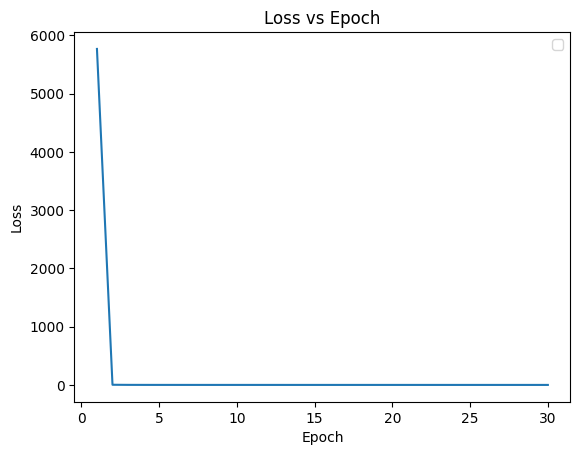

In [44]:
# Training Model
train(model, dataloader)

In [45]:
from openpyxl import load_workbook

#Specify the Workbook
excel_file = r"/home2/hardik_2001cs27/utad/experiments/results_world.xlsx"
wb_append = load_workbook(excel_file)
sheet = wb_append.active
#Writing to C1 Cell
sheet["A1"] = "Input Sentence"
sheet["B1"] = "Masking Pattern"
sheet["C1"] = "Masked Sentence"
sheet["D1"] = "Reconstructed Sentence"
#Save the operation
wb_append.save(excel_file)

# open test file
with open(r"/home2/hardik_2001cs27/utad/datasets/ag_od/test/world.txt",'r') as f:
   file22 = f.read()
def split_lines(text, n):
    words = text.split()
    lines = [' '.join(words[i:i+n]) for i in range(0, len(words), n)]
    return lines

# Split the paragraph into lines after every 10 words
file2 = split_lines(file22, 100)

In [ ]:
import torch

idx = 2
for line in file2:
    line = clean_text(line)
    inputs2 = tokenizer([line], max_length=100, truncation=True, padding='max_length', return_tensors='pt')
    inputs2['labels'] = inputs2['input_ids']
    inp_ids2 = []
    for inp in inputs2.input_ids.numpy():
        actual_tokens2 = list(set(range(100)) - 
                            set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
        num_of_token_to_mask2 = int(len(actual_tokens2) * 0.15)
        token_to_mask2 = np.random.choice(np.array(actual_tokens2), 
                                          size=num_of_token_to_mask2, 
                                          replace=False).tolist()
        
        for word in token_to_mask2:
            inp[word] = 103
        inp_ids2.append(inp)
    inp_ids2 = torch.tensor(inp_ids2)
    inputs2['input_ids'] = inp_ids2 

    mask_loc = torch.where(inputs2['input_ids'][0] == 103)[0].tolist()
    out = predict(model, inputs2['input_ids'])

    predicted_tokens = out[mask_loc]

    outputt = tokenizer.decode(predicted_tokens)
    outputt = list(outputt.split())
    for i in range(0, len(token_to_mask2)-len(outputt)):
        token_to_mask2.pop()
    masking_pattern = ""
    for i in range(0, 100):
        masking_pattern += "0"
    listt = list(masking_pattern)
    for word in token_to_mask2:
        listt[word]='1'
    masking_pattern = ''.join(listt)
    print(f"masking pattern: {masking_pattern}")
    # add outputt to excel file
    splitted_line = line.split()
    splitted_line2 = line.split()
    idxxx=0
    idxoo=0
    for ch in masking_pattern:
        if ch=='1':
            splitted_line[idxxx]="[MASK]"
            splitted_line2[idxxx]=outputt[idxoo]
            idxoo+=1
        idxxx+=1
    new_line = ""
    for word in splitted_line:
        new_line += word
        new_line += " "
    new_line2 = ""
    for word in splitted_line2:
        new_line2 += word
        new_line2 += " "
    print(f"input sentence: {line}")
    print(f"masked sentence: {new_line}")
    print(f"reconstructed sentence: {new_line2}")
    col1 = f"A{idx}"
    col2 = f"B{idx}"
    col3 = f"C{idx}"
    col4 = f"D{idx}"
    wb_append = load_workbook(excel_file)
    sheet = wb_append.active
    sheet[col1] = line
    sheet[col2] = masking_pattern
    sheet[col3] = new_line
    sheet[col4] = new_line2
    #Save the operation
    wb_append.save(excel_file)
    idx+=1
